<a href="https://colab.research.google.com/github/BinarySstar/Credit-Card-Segment-Classfication/blob/master/Credit_Card_Segment_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Mount
train 및 test 데이터를 drive에 저장하기 위해 mount를 진행

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 한글 폰트 적용을 위해 폰트 설치 및 적용

In [11]:
# 한글 폰트 설정 (Colab용)
!apt-get -qq install -y fonts-nanum
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# EDA
## 데이터 로드
- parquet 형식의 데이터를 로드

In [3]:
!pip install fastparquet

- 전체 parquet 파일에 대한 요약

In [4]:
# import pandas as pd
# import os
# from glob import glob

# # Google Drive 경로 설정
# base_path = "drive/MyDrive/고급프로그래밍/train"

# # 폴더 이름 정의
# folder_name = ["회원정보", "신용정보", "승인매출정보", "청구입금정보", "잔액정보", "채널정보", "마케팅정보", "성과정보"]
# folders = [f"{i}.{name}" for i, name in enumerate(folder_name, start=1)]

# # 요약 결과를 정리하는 list
# summary_list = []

# for folder in folders:
#     folder_path = os.path.join(base_path, folder)
#     parquet_files = glob(os.path.join(folder_path, "*.parquet"))

#     for file in parquet_files:
#         try:
#             df = pd.read_parquet(file, engine="fastparquet")

#             info = {
#                 "폴더명": folder,
#                 "파일명": file,
#                 "행 수": df.shape[0],
#                 "열 수": df.shape[1],
#                 "컬럼 목록": df.columns.tolist(),
#                 "데이터 타입": df.dtypes.to_dict(),
#                 "결측치 비율": df.isnull().mean().to_dict(),
#                 "샘플 데이터": df.head().to_dict()
#             }

#             summary_list.append(info)
#             print(f"✅ {file} 로드 완료")

#         except Exception as e:
#             print(f"❌ {file} 처리 중 오류: {e}")

# # 결과 DataFrame으로 정리
# summary_df = pd.DataFrame(summary_list)
# summary_df

✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201809_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201808_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201807_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201810_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201812_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/1.회원정보/201811_train_회원정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201807_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201808_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201809_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201812_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201810_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/2.신용정보/201811_train_신용정보.parquet 로드 완료
✅ drive/MyDrive/고급프로그래밍/train/3.승인매출정보/201807_train_승인매출정보.parquet 로드 완료


KeyboardInterrupt: 

- 모든 parquet 파일의 row는 400000개, column은 카테고리 별로 동일하다.
  - EDA를 수행할 때 메모리 효율성과 속도를 고려한 분석 전략이 중요하다.
- 카테고리 별로 column의 데이터 타입과 의미가 동일하다.


## 세그먼트 불균형 확인
- 전체 Segment(A~E)의 데이터 불균형 정도 확인
- 월별 Segment 분포 변화 확인하여 시계열 성격 확인
- 각 Segment별 고객 수 비율 및 월별 증감 여부 파악

Segment
A       162
B        24
C     21265
D     58207
E    320342
Name: count, dtype: int64
Segment
A    0.000405
B    0.000060
C    0.053163
D    0.145517
E    0.800855
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


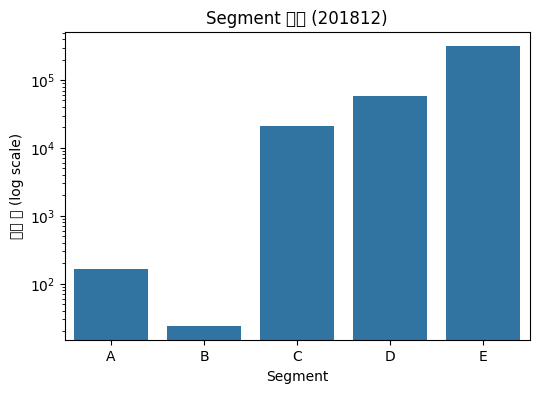

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


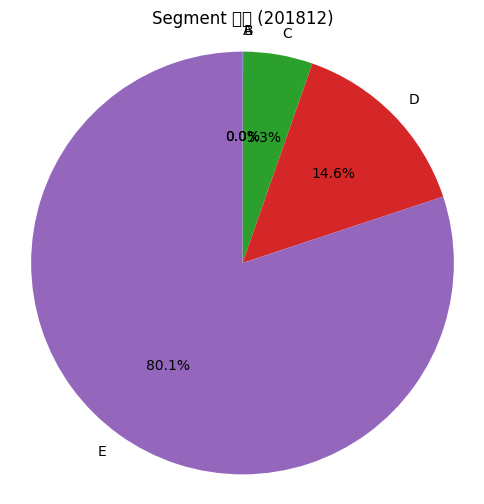

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 회원정보 데이터 불러오기 (201812 기준)
file_path = "/content/drive/MyDrive/고급프로그래밍/train/1.회원정보/201812_train_회원정보.parquet"
df = pd.read_parquet(file_path)

# Segment 분포 확인
segment_counts = df["Segment"].value_counts().sort_index()
print(segment_counts)

print("=========================")
segment_ratio = df["Segment"].value_counts(normalize=True).sort_index()
print(segment_ratio)

# 수 확인
plt.figure(figsize=(6,4))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.yscale("log")
plt.title("Segment 분포 (201812)")
plt.ylabel("고객 수 (log scale)")
plt.xlabel("Segment")
plt.show()

# 비율 확인
plt.figure(figsize=(6,6))
plt.pie(segment_ratio, labels=segment_ratio.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Segment 비율 (201812)")
plt.axis('equal')
plt.show()

In [ ]:
# import pandas as pd
# import pyarrow.parquet as pq
# import os
# import random
# import gc

# # 설정
# train_path = "/content/drive/MyDrive/고급프로그래밍/train"
# folder_list = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])

# # 샘플링 설정
# SAMPLING_NUM = 1000
# MAX_ROW_ESTIMATE = 40000
# RANDOM_SEED = 42
# sample_indices = sorted(random.Random(RANDOM_SEED).sample(range(MAX_ROW_ESTIMATE), SAMPLING_NUM))

# # 샘플 저장용 딕셔너리 (숫자 key 사용)
# sample_dict = {}

# for folder in folder_list:
#     folder_path = os.path.join(train_path, folder)
#     folder_num = folder.split(".")[0]  # "1.회원정보" → "1"
#     file_list = sorted([f for f in os.listdir(folder_path) if f.endswith(".parquet")])

#     df_list = []

#     for file in file_list:
#         file_path = os.path.join(folder_path, file)
#         try:
#             parquet_file = pq.ParquetFile(file_path)
#             total_rows = parquet_file.metadata.num_rows

#             effective_indices = [i for i in sample_indices if i < total_rows]
#             if not effective_indices:
#                 continue

#             min_idx, max_idx = effective_indices[0], effective_indices[-1] + 1
#             table = parquet_file.read().slice(min_idx, max_idx - min_idx)
#             df_slice = table.to_pandas()
#             df_sampled = df_slice.iloc[[i - min_idx for i in effective_indices]]
#             df_list.append(df_sampled)

#         except Exception as e:
#             print(f"❌ 오류: {file} - {e}")

#     if df_list:
#         category_df = pd.concat(df_list, ignore_index=True)
#         category_df["ID"] = category_df["ID"].astype(str)
#         sample_dict[folder_num] = category_df  # 숫자 key로 저장

# # 중간 저장용 폴더 생성
# save_dir = "/content/drive/MyDrive/고급프로그래밍/sample_chunks"
# os.makedirs(save_dir, exist_ok=True)

# # 샘플링된 각 카테고리 데이터를 parquet로 저장 (파일당 저장)
# for key, df in sample_dict.items():
#     df.to_parquet(os.path.join(save_dir, f"{key}.parquet"), index=False)
#     print(f"✅ 저장 완료: {key}.parquet")

In [ ]:
# import dask.dataframe as dd
# import os
# import gc

# # 설정
# save_dir = "/content/drive/MyDrive/고급프로그래밍/sample_chunks"  # 샘플 데이터 저장 경로

# # Dask로 첫 번째 파일 로드 (기준 파일)
# base_key = "1"  # 회원정보 기준
# base_path = os.path.join(save_dir, f"{base_key}.parquet")
# joined_df = dd.read_parquet(base_path, engine="pyarrow", blocksize="64MB")  # 파티션 크기 설정
# joined_df["ID"] = joined_df["ID"].astype(str)  # ID 컬럼을 문자열로 변환

# # 나머지 카테고리들을 순차적으로 병합
# for k in range(2, 9):  # 2부터 8까지
#     file_path = os.path.join(save_dir, f"{k}.parquet")
#     if not os.path.exists(file_path):
#         print(f"❗ 파일 없음: {file_path} → 건너뜀")
#         continue

#     # Dask로 파일 읽기
#     df = dd.read_parquet(file_path, engine="pyarrow", blocksize="64MB")  # 파티션 크기 설정
#     df["ID"] = df["ID"].astype(str)  # ID 컬럼을 문자열로 변환

#     print(f"🧩 병합 중: {k}.parquet → ({df.shape[1]} columns)")

#     # 병합 (ID 기준)
#     joined_df = dd.merge(joined_df, df, on="ID", how="left", suffixes=('', f'_{k}'))

#     # 중간 결과를 디스크에 저장하여 메모리 절약
#     joined_df.to_parquet(os.path.join(save_dir, f"joined_{k}.parquet"))

#     # 메모리 절약을 위해 필요 없는 변수 삭제 후 가비지 컬렉션
#     del df
#     gc.collect()

# # 최종 결과 계산 (Dask DataFrame을 Pandas로 변환)
# final_df = joined_df.compute()  # 최종 결과를 Pandas DataFrame으로 변환

# # 결과 확인
# print(f"✅ 최종 병합 완료: {final_df.shape}")
# final_df.head(10)


## 데이터 샘플링

- 대용량 데이터를 전체 처리하는 것은 현실적으로 불가능함
  - 각 parquet의 row는 240,000개, column 개수가 상이함.
  - 도메인 지식도 부족
- 데이터를 일부 샘플링하여 해당 데이터에 대한 통계 및 분석하여 가설을 세운다.



In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pyarrow.parquet as pq
# import os
# import random

# # 경로 설정
# merged_path = "/content/drive/MyDrive/고급프로그래밍/merged"
# file_list = sorted([f for f in os.listdir(merged_path) if f.endswith(".parquet")])

# SAMPLING_NUM = 1000
# ROWS = 240000
# RANDOM_SEED = 42

# # 샘플로 추출할 row index
# sample_indices = sorted(random.Random(RANDOM_SEED).sample(range(ROWS), SAMPLING_NUM))

# # 결과 저장용 리스트
# sample_df = []

# for file in file_list:
#     file_path = os.path.join(merged_path, file)
#     print(f"{file_path} → 데이터 샘플링 중...")

#     try:
#         parquet_file = pq.ParquetFile(file_path)
#         total_rows = parquet_file.metadata.num_rows

#         # 최소-최대 슬라이스 후 원하는 행만 선택
#         min_idx, max_idx = sample_indices[0], sample_indices[-1] + 1
#         table = parquet_file.read_row_group(0) if parquet_file.num_row_groups == 1 else parquet_file.read()
#         df_slice = table.slice(min_idx, max_idx - min_idx).to_pandas()
#         df_sampled = df_slice.iloc[[i - min_idx for i in sample_indices]]

#         df_sampled["__source_file__"] = file  # 출처 파일 정보 추가
#         sample_df.append(df_sampled)

#         print(f"✅ 완료: {file} ({df_sampled.shape[0]} rows)")

#     except Exception as e:
#         print(f"⚠️ 오류 발생: {file} - {e}")

# # 최종 샘플 데이터 결합
# combined_sample_df = pd.concat(sample_df, ignore_index=True)
# combined_sample_df.head(10)

In [ ]:
# combined_sample_df.tail(10)

In [ ]:
# combined_sample_df